# 0. Install Dependencies and Bring in Data

In [1]:
# !pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [7]:
os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv')

'jigsaw-toxic-comment-classification-challenge/train.csv'

In [8]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv'))

In [9]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [28]:
df[df['toxic'] == 1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [32]:
df.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [34]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

# 1. Preprocess

In [35]:
from tensorflow.keras.layers import TextVectorization

In [37]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [38]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [39]:
df['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [41]:
df[df.columns[2:]].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [44]:
MAX_FEATURES = 200000       # no. of words in the vocab

In [45]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,      # how many words we want in vocab
                               output_sequence_length=1800,  # max. length of the output or input
                               output_mode = 'int'           # output in int
                               )

Metal device set to: Apple M1


2022-09-18 20:15:36.716728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-18 20:15:36.717551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [52]:
type(X) 

pandas.core.series.Series

In [53]:
type(X.values)

numpy.ndarray

In [46]:
vectorizer.adapt(X.values)

2022-09-18 20:17:21.098047: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-18 20:17:21.158596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [57]:
vectorizer('hello world, life is good')[:5]              # example of embedding (remove puntuation)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263, 306,   9,  98])>

In [65]:
vectorizer_text = vectorizer(X.values)

In [66]:
len(X)

159571

In [67]:
vectorizer_text           # if snetence is bigger than 1800 it will pad out values with 0

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [69]:
# MCSHBAP  - map, cache, shuffle, batch, predetch from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text, y))
dataset = dataset.cache()                 # cache your data
dataset = dataset.shuffle(160000)         # how large buffer we need
dataset = dataset.batch(16)               # batches it up ( each batch representes as  16 samples )
dataset = dataset.prefetch(8)             # helps bottlenecks

In [70]:
dataset.as_numpy_iterator().next()

(array([[ 16128,      4,  13414, ...,      0,      0,      0],
        [ 20306,  20306,     62, ...,      0,      0,      0],
        [   920,     40,      2, ...,      0,      0,      0],
        ...,
        [     8,     69,      2, ...,      0,      0,      0],
        [  1139,      8,    660, ...,      0,      0,      0],
        [    77,  51905, 127315, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [71]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [73]:
print(batch_X.shape)
print(batch_y.shape)

(16, 1800)
(16, 6)


In [74]:
len(dataset)

9974

In [75]:
int(len(dataset)*.7)

6981

In [87]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [88]:
len(train),len(val),len(test)

(6981, 1994, 997)

In [89]:
train_generator = train.as_numpy_iterator()

In [90]:
train_generator.next()

(array([[  125,    74,     8, ...,     0,     0,     0],
        [   73,  2357,     7, ...,     0,     0,     0],
        [ 1120,  5254,   893, ...,     0,     0,     0],
        ...,
        [   86,     2,  3335, ...,     0,     0,     0],
        [  621,   206,   433, ...,     0,     0,     0],
        [  413,   303, 13762, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# 2. Create Sequential Model

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [97]:
Bidirectional??

Init signature:
Bidirectional(
    layer,
    merge_mode='concat',
    weights=None,
    backward_layer=None,
    **kwargs,
)
Source:        
@keras_export('keras.layers.Bidirectional')
class Bidirectional(Wrapper):
  """Bidirectional wrapper for RNNs.

  Args:
    layer: `keras.layers.RNN` instance, such as `keras.layers.LSTM` or
      `keras.layers.GRU`. It could also be a `keras.layers.Layer` instance
      that meets the following criteria:
      1. Be a sequence-processing layer (accepts 3D+ inputs).
      2. Have a `go_backwards`, `return_sequences` and `return_state`
        attribute (with the same semantics as for the `RNN` class).
      3. Have an `input_spec` attribute.
      4. Implement serialization via `get_config()` and `from_config()`.
      Note that the recommended way to create new RNN layers is to write a
      custom RNN cell and use it with `keras.layers.RNN`, instead of
      subclassing `keras.layers.Layer` directly.
      - When the `returns_sequences` is true

In [94]:
model = Sequential()            # instantiate our model ( this will instantiate the seq. api)
# create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM layer
# this layer allows you to pass info. backward and forward across your LSTM layer
# why bidirectional ? becasuse take a sentence 'i don't hate you' if out NN only sees in forward direction
# it might see the word 'hate' as a last value and interpret it as a Negatice sentence.
model.add(Bidirectional(LSTM(32, activation='tanh'))) 
# Feature extraxtor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# final layer
model.add(Dense(6, activation='sigmoid'))

In [95]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [96]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [99]:
history = model.fit(train, epochs=1, validation_data=val)

2022-09-18 21:42:27.622403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 21:42:27.995086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 21:42:28.006750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 21:42:41.703147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 21:42:41.718388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6981/6981 [==============================] - ETA: 0s - loss: 0.0621

2022-09-19 00:19:11.107689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-19 00:19:12.076613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-19 00:19:12.102221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6981/6981 [==============================] - 10658s 2s/step - loss: 0.0621 - val_loss: 0.0441


In [100]:
history.history

{'loss': [0.062066733837127686], 'val_loss': [0.04411913454532623]}

In [101]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

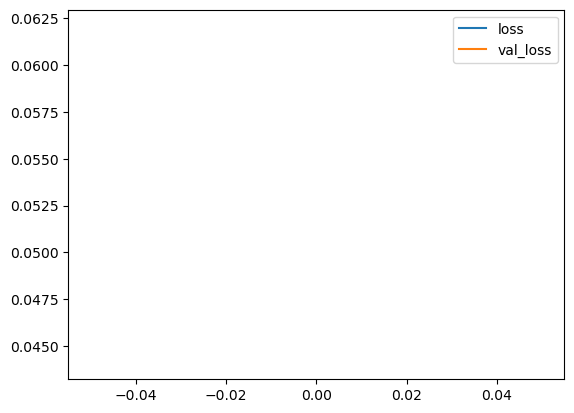

In [102]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [103]:
input_text = vectorizer('you freaking suck!')

In [104]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [105]:
batch = test.as_numpy_iterator().next()

In [106]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [107]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [110]:
(model.predict(batch_X)>0.5).astype(int)   

2022-09-19 00:40:59.520185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-19 00:40:59.618683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-19 00:40:59.644123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 13s 13s/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [111]:
model.predict(np.expand_dims(input_text))   # np.array([input_text]) because it is expecting 16*1800*32

TypeError: _expand_dims_dispatcher() missing 1 required positional argument: 'axis'

In [112]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 14s 14s/step


# 4. Evaluate Model

In [113]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [114]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [115]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 1s 631ms/step


In [116]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8291161060333252, Recall:0.6797385215759277, Accuracy:0.48345035314559937


# 5. Test and Gradio

In [ ]:
import tensorflow as tf
import gradio as gr

In [117]:
model.save('toxicity.h5')

In [118]:
model = tf.keras.models.load_model('toxicity.h5')

In [119]:
input_str = vectorizer('hey i freaken hate you!')

In [120]:
res = model.predict(np.expand_dims(input_str,0))

2022-09-19 00:53:18.384740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-19 00:53:18.461845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-19 00:53:18.469338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 12s 12s/step


In [121]:
res

array([[0.7386025 , 0.02712291, 0.38903287, 0.01969793, 0.40258798,
        0.07200838]], dtype=float32)

In [122]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)